In [1]:
import os
import tqdm
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn import metrics
from preprocessors import *
from sklearn.metrics import *
from datetime import datetime
import matplotlib.pyplot as plt
from Dataset import SpeechDataset
from DataLoader import DataLoader
from xgboost import XGBClassifier
from sklearn.preprocessing import *
from matplotlib.pyplot import figure
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

/home/m_hovo/Desktop/KU Leuven/Modern Data Analytics/mda-project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cwd = os.getcwd()
dataset_types = ["important", "typical"]
resources_dir = f"{cwd}/resources"
saving_dir = f"{cwd}/resources/dataset_all.csv"

# Dataset Creation and Extraction of Importance Measures

In [4]:
if not os.path.exists(saving_dir):
    df_dict = {
        "speaker": [], "title": [], "year": [], "content": [],
        "anger": [], "disgust": [], "disgust": [], "joy": [], "neutral": [], "sadness": [], "surprise": [],
        "polarity": [], "subjectivity": [], "complexity": [], "lexical_richness": [],
        "entities_proportion_in_speech": [], "imagery_proportion_in_speech": [],
        "stopwords_proportion_in_speech": [], "mean_sentence_length": [],
        "label": []
    }

    imagery_words = pd.read_csv("resources/visual_words.csv", header=None)
    imagery_words = list(imagery_words[0].array)
    stop_words = list(spacy.load("en_core_web_md").Defaults.stop_words)

    for dataset_type in dataset_types:
        path = f"{cwd}/dataset/{dataset_type}"
        dataset = SpeechDataset(path)
        dataloader = DataLoader(dataset)
        with tqdm(total=len(dataloader.dataset)) as progress_bar:
            for speech in dataloader:
                for key in df_dict.keys():
                    try:
                        df_dict[key].append(getattr(speech, f"get_{key}")())
                    except:
                        pass
                emotions = speech.get_emotion_scores(return_all_scores=True)[0]
                for emotion in emotions:
                    df_dict[emotion["label"]].append(emotion["score"])

                df_dict["entities_proportion_in_speech"].append(speech.get_proportion_in_speech(speech.get_entities()))
                df_dict["imagery_proportion_in_speech"].append(speech.get_proportion_in_speech(imagery_words))
                df_dict["stopwords_proportion_in_speech"].append(speech.get_proportion_in_speech(stop_words))
                if dataset_type == "important":
                    df_dict["label"].append(1.0)
                else:
                    df_dict["label"].append(0.0)
                progress_bar.update(1)

    if not os.path.exists(resources_dir):
        os.mkdir(resources_dir)
    df = pd.DataFrame(df_dict)
    df.to_csv(saving_dir)
else:
    df = pd.read_csv(saving_dir)

# Importance Measures and EDA

##### More speeches with high fear (> 0.2) in important than typical.
##### Fewer speeches with high joy (> 0.2) in important than typical.
##### Fewer speeches with high neutrality (> 0.2) in important than typical.
##### Fewer speeches with low surprise (< 0.2) in important than typical.
##### Fewer speeches with polarity (>0.15) in important than typical.
##### More speeches with high subjectivity (>0.4) in important than typical.
##### Fewer speeches with low complexity (>60) in important than in typical.
##### Fewer speeches with high lexical richness (>0.3) in important than in typical.
##### Fewer speeches with high proportion of entities (> 0.02) in imporant than typical.
##### Fewer speeches with high proportion of imagery words (>0.075) in important than in typical.
##### Fewer speaches with high proportion (>0.05) of stopwords in important than in typical.
##### More speeches with high (>20) mean sentence length in important than in typical.

In [ ]:
for colname in df.columns[5:-1]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.bar(list(range(0, len(df[df["label"] == 1][colname].array))), df[df["label"] == 1][colname].array)
    ax1.set_xlabel("Speech Name")
    ax1.set_ylabel(f"{colname} score")
    ax1.set_title(f"Important Speeches vs {colname} Score")
    ax2.bar(list(range(0, len(df[df["label"] == 0][colname].array))), df[df["label"] == 0][colname].array)
    ax2.set_xlabel("Speech Name")
    ax2.set_ylabel(f"{colname} score")
    ax2.set_title(f"Typical Speeches vs {colname} Score")
    plt.show()

In [ ]:
for colname in df.columns[5:-1]:
    plt.figure(figsize=(6, 4))
    sns.violinplot(x="label", y=colname, data=df)
    plt.show()

### The influence of fear, neutrality and subjectivity, the proportion of named entities and stop‐ words, and the proportion of imagery words on speeches

In [ ]:
figure(figsize=(10, 10))
plt.bar(list(range(0, len(df[df["label"] == 1]["fear"].array))), df[df["label"] == 1]["fear"].array, label="Important",
        color="#005e77")
plt.bar(list(range(0, len(df[df["label"] == 0]["fear"].array))), df[df["label"] == 0]["fear"].array, label="Typical",
        color="#8c949a")
plt.plot(list(range(0, len(df[df["label"] == 0]["fear"].array))),
         0.2 * np.ones(len(df[df["label"] == 0]["fear"].array)), color="#2f4d5d", linestyle="--")
plt.xlim(0, 77)
plt.xlabel("Speech")
plt.ylabel("Fear")
plt.legend(loc=1)

In [ ]:
figure(figsize=(10, 4))
plt.plot(list(range(0, len(df[df["label"] == 1]["neutral"].array))), df[df["label"] == 1]["neutral"].array,
         label="Neutrality", color="#005e77")
plt.plot(list(range(0, len(df[df["label"] == 1]["subjectivity"].array))), df[df["label"] == 1]["subjectivity"].array,
         label="Subjectivity", color="#8c949a")
plt.plot(list(range(0, len(df[df["label"] == 0]["fear"].array))),
         0.2 * np.ones(len(df[df["label"] == 0]["neutral"].array)), color="#005e77", linestyle="--")
plt.plot(list(range(0, len(df[df["label"] == 0]["fear"].array))),
         0.4 * np.ones(len(df[df["label"] == 0]["subjectivity"].array)), color="#8c949a", linestyle="--")

plt.xlim(0, 77)
plt.xlabel("Speech")
plt.ylabel("Score")
plt.legend(loc=1)

In [ ]:
figure(figsize=(10, 4))
plt.scatter(list(range(0, len(df[df["label"] == 1]["entities_proportion_in_speech"].array))),
            df[df["label"] == 1]["entities_proportion_in_speech"].array, label="Proportion of entities",
            color="#005e77")
plt.scatter(list(range(0, len(df[df["label"] == 1]["stopwords_proportion_in_speech"].array))),
            df[df["label"] == 1]["stopwords_proportion_in_speech"].array, label="Proportion of stopwords",
            color="#8c949a")
plt.plot(list(range(0, len(df[df["label"] == 0]["fear"].array))),
         0.02 * np.ones(len(df[df["label"] == 0]["entities_proportion_in_speech"].array)), color="#005e77",
         linestyle="--")
plt.plot(list(range(0, len(df[df["label"] == 0]["fear"].array))),
         0.05 * np.ones(len(df[df["label"] == 0]["entities_proportion_in_speech"].array)), color="#8c949a",
         linestyle="--")
plt.xlim(0, 77)
plt.xlabel("Speech")
plt.ylabel("Score")
plt.legend(loc=1)

In [ ]:
figure(figsize=(10, 4))
plt.bar(list(range(0, len(df[df["label"] == 1]["imagery_proportion_in_speech"].array))),
        df[df["label"] == 1]["imagery_proportion_in_speech"].array, label="Important", color="#005e77")
plt.bar(list(range(0, len(df[df["label"] == 0]["imagery_proportion_in_speech"].array))),
        df[df["label"] == 0]["imagery_proportion_in_speech"].array, label="Typical", color="#8c949a")
plt.plot(list(range(0, len(df[df["label"] == 0]["fear"].array))),
         0.075 * np.ones(len(df[df["label"] == 0]["imagery_proportion_in_speech"].array)), color="#2f4d5d",
         linestyle="--")
plt.xlim(0, 77)
plt.xlabel("Speech")
plt.ylabel("Score")
plt.legend(loc=1)

### Correlation Analysis of features

In [ ]:
data = df.iloc[:, 5:-1]
correlation_d = data.corr()
mask = np.triu(np.ones_like(correlation_d, dtype=bool))
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_d, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5)

corr_abs = correlation_d.abs()
unstacked_v = corr_abs.unstack()
sort_v = pd.DataFrame(unstacked_v.sort_values(kind='quicksort'), columns=['correlation'])

# Classification
### Logistic Regression, Support Vectors, Random Forest (Bagging approach), and Extreme Gradient (Boosting approach)


In [ ]:
grid_param_dict = {}
N_FEATURES_OPTIONS = [2, 4, 6, 8, 10, 12, 14, 15]
C_OPTIONS = [1, 10, 100, 1000]
k_neigbors = [1, 2, 3, 4, 5]

param_grid_XGBoost = {"XGBoost": [{
    'encoder': [StandardScaler(), RobustScaler()],
    "clf__learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "clf__max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "clf__min_child_weight": [1, 3, 5, 7],
    "clf__gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "clf__colsample_bytree": [0.3, 0.4, 0.5, 0.7]}]}
param_grid_SVC = {"svm": [{
    'encoder': [StandardScaler(), RobustScaler()],
    'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'clf__gamma': [100, 10, 1, 0.1, 0.2, 0.02, 0.002, 0.0002, 0.01, 0.001, 0.0001],
    'clf__kernel': ['rbf', 'linear']}]}
param_grid_LR = {"logistic": [{
    'encoder': [StandardScaler(), RobustScaler()],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.001, 0.01, 0.1, 1],
    'clf__solver': ['liblinear']}]}
param_grid_RF = {"RandomForest": [{
    'encoder': [StandardScaler(), RobustScaler()],
    'clf__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'clf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'clf__min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]}

grid_param_dict.update(param_grid_SVC)
grid_param_dict.update(param_grid_LR)
grid_param_dict.update(param_grid_RF)
grid_param_dict.update(param_grid_XGBoost)

saving_dir = f"{cwd}/results/MLA_compare.csv"
data = np.array(df.iloc[:, 5:-1])
target = np.array(df.iloc[:, -1])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3,
                                                    stratify=target, random_state=109)
model_dict = {
    'logistic': LogisticRegression(random_state=11, max_iter=10000),
    'svm': svm.SVC(probability=True),
    'RandomForest': RandomForestClassifier(verbose=True, n_estimators=500),
    'XGBoost': XGBClassifier(verbose=True),
}

classification_comparison_columns = []
classification_comparison_columns = pd.DataFrame(columns=classification_comparison_columns)
results = []

cv = KFold(n_splits=5, shuffle=True, random_state=1)
for i, model in enumerate(model_dict.keys()):
    print(model)
    start = datetime.now()
    pipe = Pipeline(steps=[('encoder', "passthrough"), ("reduce_dim", "passthrough"), 
                           ('clf', model_dict[model])])

    grid = GridSearchCV(pipe, n_jobs=-1, param_grid=grid_param_dict[model],
                        cv=cv, scoring='accuracy', refit=True, verbose=0)
    grid.fit(X_train, y_train)
    end = datetime.now()

    y_pred = grid.predict(X_test)
    y_train_pred = grid.predict(X_train)
    y_train_pred_scores = grid.predict_proba(X_train)[:, 1]
    y_test_pred_scores = grid.predict_proba(X_test)[:, 1]

    roc_train = roc_auc_score(y_train, y_train_pred_scores)
    accuracy_train = metrics.accuracy_score(y_train, y_train_pred)
    roc_test = roc_auc_score(y_test, y_test_pred_scores)
    ac_test = metrics.accuracy_score(y_test, y_pred)

    MLA_name = model_dict[model].__class__.__name__
    classification_comparison_columns.loc[i, 'Name'] = MLA_name
    classification_comparison_columns.loc[i, 'Tuned Hyperparameters'] = str(grid.best_params_)
    classification_comparison_columns.loc[i, 'Train_Accuracy'] = accuracy_train
    classification_comparison_columns.loc[i, 'Test_Accuracy'] = round(ac_test, 4)
    classification_comparison_columns.loc[i, 'Tran_ROC'] = round(roc_train, 4)
    classification_comparison_columns.loc[i, 'Test_ROC'] = round(roc_test, 4)
    classification_comparison_columns.loc[i, 'duration_minutes'] = (end - start).total_seconds() / 60
classification_comparison_columns.to_csv(saving_dir, sep=',', index=False)
classification_comparison_columns['Tuned Hyperparameters']

### Final Chosen Model and Feature Importance
### Random Forests
#### Test Accuracy: 76.6

Train Accuracy : 0.8598130841121495
Test  Accuracy : 0.7446808510638298
Train ROC Accuracy : 0.9371069182389937
Test ROC Accuracy : 0.7807971014492754


X has feature names, but RandomForestClassifier was fitted without feature names

X has feature names, but RandomForestClassifier was fitted without feature names

X has feature names, but RandomForestClassifier was fitted without feature names

X has feature names, but RandomForestClassifier was fitted without feature names

X has feature names, but RandomForestClassifier was fitted without feature names

X has feature names, but RandomForestClassifier was fitted without feature names

X has feature names, but RandomForestClassifier was fitted without feature names

X has feature names, but RandomForestClassifier was fitted without feature names

X has feature names, but RandomForestClassifier was fitted without feature names

X has feature names, but RandomForestClassifier was fitted without feature names

X has feature names, but RandomForestClassifier was fitted without feature names

X has feature names, but RandomForestClassifier was fitted without feature names

X has feature na

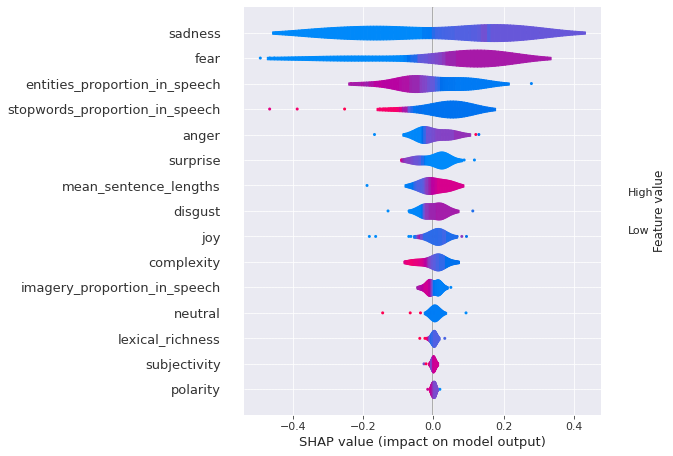

In [5]:
data = np.array(df.iloc[:, 5:-1])
target = np.array(df.iloc[:, -1])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3,
                                                    stratify=target, random_state=109)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

model=RandomForestClassifier(verbose = 0, n_estimators=500, max_depth= 4,
                             min_samples_leaf= 2,min_samples_split= 42)

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

y_train_pred_scores=model.predict_proba(X_train_scaled)[:,1]
y_test_pred_scores=model.predict_proba(X_test_scaled)[:,1]

roc_train=roc_auc_score(y_train, y_train_pred_scores)
roc_test=roc_auc_score(y_test, y_test_pred_scores)
ac_train= metrics.accuracy_score(y_train, y_train_pred)
ac_test= metrics.accuracy_score(y_test, y_test_pred)
print("Train Accuracy :",ac_train)
print("Test  Accuracy :",ac_test)
print("Train ROC Accuracy :",roc_train)
print("Test ROC Accuracy :",roc_test)


feature_names =df.iloc[:, 5:-1].columns
df_X_train_scaled = pd.DataFrame(X_train_scaled,columns=feature_names)
df_X_test_scaled = pd.DataFrame(X_test_scaled,columns=feature_names)
explainer = shap.Explainer(model.predict, df_X_test_scaled)
shap_values = explainer(df_X_test_scaled)
shap.summary_plot(shap_values, plot_type='violin')

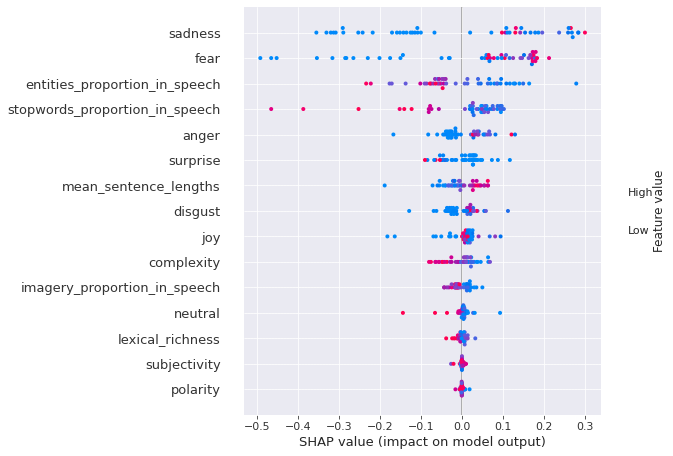

In [6]:
shap.summary_plot(shap_values)